# Hito 12: Temporal decorrelation in audio signals

 **Grupo 4:**
* Ángel Luis Labraca Miranda
* Francisco José López Carrillo
* David Valdivia Aguilera
* Alejo Martín Arias Filippo

In [40]:
import sounddevice as sd
import pywt # pip install pywavelets
import math
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from scipy import signal
import zlib
import pylab

In [41]:
def plot(y, xlabel='', ylabel='', title=''):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.grid()
    ax.xaxis.set_label_text(xlabel)
    ax.yaxis.set_label_text(ylabel)
    x = np.linspace(0, len(y)-1, len(y))
    ax.plot(x, y, '.', markersize=1)
    plt.show(block=False)

# Recogemos 5 segundos de audio

In [42]:
fs = 44100      # Sampling frequency
duration = 5.0  # seconds
signal = sd.rec(int(duration * fs), samplerate=fs, channels=2, dtype=np.int16)
print("Say something!")

while sd.wait():
    pass
print("done")

Say something!
done


# Modulos para RD 

In [43]:

def average_energy(x):

    #return np.sum(x[:, 0].astype(np.double)*x[:, 0].astype(np.double))/len(x[:, 0]) + \

    #       np.sum(x[:, 1].astype(np.double)*x[:, 1].astype(np.double))/len(x[:, 1])

    return np.sum(x.astype(np.double)*x.astype(np.double))/len(x)


def RMSE(x, y):

    error_signal = x - y

    return math.sqrt(average_energy(error_signal))


# Based on https://stackoverflow.com/questions/15450192/fastest-way-to-compute-entropy-in-python

def entropy_in_bits_per_symbol(sequence_of_symbols):

    value, counts = np.unique(sequence_of_symbols, return_counts = True)

    probs = counts / len(sequence_of_symbols)

    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:

        return 0

    entropy = 0.

    for i in probs:

        entropy -= i * math.log(i, 2)

    return entropy

def deadzone_quantizer(x, quantization_step):

    k = (x / quantization_step).astype(np.int)

    return k


def deadzone_dequantizer(k, quantization_step):

    y = quantization_step * k

    return y


def deadzone_qdeq(x, quantization_step):

    k = deadzone_quantizer(x, quantization_step)

    y = deadzone_dequantizer(k, quantization_step)

    return k, y


def RD_curve(data, analyze, synthesize):

    RD_points = []

    for q_step in range(16, 1024, 32):

        analyzed_data = analyze(data)

        k, y = deadzone_qdeq(analyzed_data, q_step)

        rate = entropy_in_bits_per_symbol(k[:, 0]) + entropy_in_bits_per_symbol(k[:, 1])

        reconstructed_data = synthesize(y)

        distortion = RMSE(data, reconstructed_data)

        RD_points.append((rate, distortion))

    return RD_points

def RD_curve_DWT(data, analyze, synthesize):

    RD_points = []

    for q_step in range(16, 1024, 32):

        analyzed_data,slices = analyze(data)

        k, y = deadzone_qdeq(analyzed_data, q_step)

        rate = entropy_in_bits_per_symbol(k[:, 0]) + entropy_in_bits_per_symbol(k[:, 1])

        reconstructed_data = synthesize(y,slices)

        distortion = RMSE(data, reconstructed_data)

        RD_points.append((rate, distortion))

    return RD_points

# Modulos del MST (hito 11)

In [44]:
# Analysis transform:
#
#  [w[0]] = [1  1] [x[0]]
#  [w[1]]   [1 -1] [x[1]]

def MST_analyze(x):
    w = np.empty_like(x, dtype=np.int32)
    w[:, 0] = x[:, 0].astype(np.int32) + x[:, 1] # L(ow frequency subband)
    w[:, 1] = x[:, 0].astype(np.int32) - x[:, 1] # H(igh frequency subband)
    return w

# Inverse transform:
#
#  [x[0]] = 1/2 [1  1] [w[0]]
#  [x[1]]       [1 -1] [w[1]]

def MST_synthesize(w):
    x = np.empty_like(w, dtype=np.int16)
    x[:, 0] = (w[:, 0] + w[:, 1])/2 # L(ow frequency subband)
    x[:, 1] = (w[:, 0] - w[:, 1])/2 # H(igh frequency subband)
    return x

# This solution is slower than the previous one because: (1) an array of int32 is allocated,
# and (2) the memory locality is smaller (the division by 2 is not performed just when
# the samples are accesed).
def _MST_synthesize(w):
    x = np.empty_like(w, dtype=np.int16)
    x[:, :] = MST_analyze(w)
    x = x / 2
    return x

# Configuracion DWT

In [45]:
levels = 3         # Number of levels of the DWT

filters_name = "haar"
#filters_name = "db11"
#filters_name = "db20"
#filters_name = "bior2.2"
#filters_name = "bior3.5"
#filters_name = "rbio2.2"
wavelet = pywt.Wavelet(filters_name)
signal_mode_extension = "per"
quantization_step = 256
chunk_size = 1024
chunk_number = 15
# Recogemos 3 chunks de audio
left_chunk = signal[chunk_size * (chunk_number - 1) : chunk_size * chunk_number]
center_chunk = signal[chunk_size * chunk_number : chunk_size * (chunk_number + 1)]
right_chunk = signal[chunk_size * (chunk_number + 1) : chunk_size * (chunk_number + 2)]
chunks = np.concatenate([left_chunk, center_chunk, right_chunk])

### Chunk extendido

In [46]:
number_of_overlaped_samples = 1 << math.ceil(math.log(wavelet.dec_len * levels) / math.log(2))
number_of_overlaped_samples
last_samples_left_chunk = left_chunk[chunk_size - number_of_overlaped_samples :]
first_samples_right_chunk = right_chunk[: number_of_overlaped_samples]
extended_chunk = np.concatenate([last_samples_left_chunk, center_chunk, first_samples_right_chunk])
print("number of samples overlaped with left_chunk =", len(last_samples_left_chunk))
print("number of samples in the center_chunk =", len(center_chunk))
print("number of samples overlaped with right_chunk =", len(first_samples_right_chunk))
print("length of the extended center_chunk =", len(extended_chunk))

number of samples overlaped with left_chunk = 8
number of samples in the center_chunk = 1024
number of samples overlaped with right_chunk = 8
length of the extended center_chunk = 1040


# Módulos DWT

In [47]:
def DWT(chunk):
    coefs = np.empty(chunk.shape, dtype=np.int32)
        
    decomposition_0 = pywt.wavedec(chunk[:,0],wavelet, level=levels)
    decomposition_1 =pywt.wavedec(chunk[:,1],wavelet, level=levels)
        
    coefs_0, slices = pywt.coeffs_to_array(decomposition_0)
    coefs_1, slices = pywt.coeffs_to_array(decomposition_1)
        
    coefs[:, 0] = np.rint(coefs_0).astype(np.int32)
    coefs[:, 1] = np.rint(coefs_1).astype(np.int32)
    
    return coefs,slices
    
def iDWT(chunk,slices):
    reconstructed_chunk =np.empty((chunk_size+(number_of_overlaped_samples*2),2),dtype=np.int32)
        
    decomposition_0 =pywt.array_to_coeffs(chunk[:,0],slices,output_format='wavedec')
    decomposition_1 =pywt.array_to_coeffs(chunk[:,1],slices,output_format='wavedec')
        
    reconstructed_chunk[:, 0] = np.rint(pywt.waverec(decomposition_0, wavelet)).astype(np.int16)
    reconstructed_chunk[:, 1] = np.rint(pywt.waverec(decomposition_1, wavelet)).astype(np.int16)
        
    return reconstructed_chunk

In [48]:
def sameData(chunk):
    return chunk

# MST vs DWT vs cuantificacion en RD

In [49]:
MST_RD_points = RD_curve(extended_chunk,MST_analyze, MST_synthesize)

In [50]:
DWT_RD_points = RD_curve_DWT(extended_chunk,DWT, iDWT)

In [51]:
Quan_RD_points = RD_curve(extended_chunk,sameData,sameData)

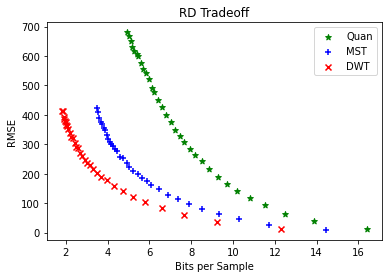

In [52]:
plt.title("RD Tradeoff")
plt.xlabel("Bits per Sample")
plt.ylabel("RMSE")
#plt.xscale("log")
#plt.yscale("log")
plt.scatter(*zip(*Quan_RD_points), c='g', marker="*", label='Quan')
plt.scatter(*zip(*MST_RD_points), c='b', marker="+", label='MST')
plt.scatter(*zip(*DWT_RD_points), c='r', marker="x", label='DWT')
plt.legend(loc='upper right')
plt.show()

# Combinamos los 3 métodos

In [53]:
def DWT_MST(chunk):
    chunk,slices = DWT(chunk)
    chunk = MST_analyze(chunk)
    return chunk,slices
def iDWT_MST(chunk,slices):
    chunk = MST_synthesize(chunk)
    chunk = iDWT(chunk,slices)
    return chunk

## Comparacion

In [54]:
DWT_MST_RD_points = RD_curve_DWT(extended_chunk,DWT_MST,iDWT_MST)

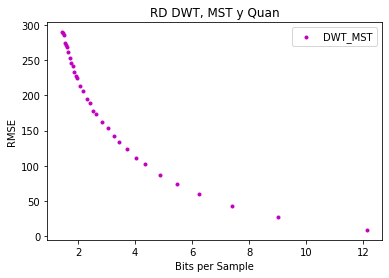

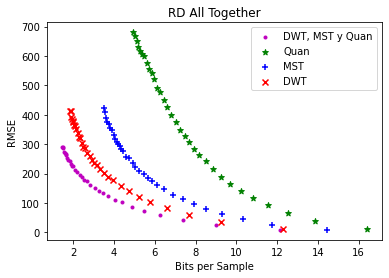

In [55]:
plt.title("RD DWT, MST y Quan")
plt.xlabel("Bits per Sample")
plt.ylabel("RMSE")
#plt.xscale("log")
#plt.yscale("log")
plt.scatter(*zip(*DWT_MST_RD_points), c='m', marker=".", label='DWT_MST')
plt.legend(loc='upper right')
plt.show()

plt.title("RD All Together")
plt.xlabel("Bits per Sample")
plt.ylabel("RMSE")
#plt.xscale("log")
#plt.yscale("log")
plt.scatter(*zip(*DWT_MST_RD_points), c='m', marker=".", label='DWT, MST y Quan')
plt.scatter(*zip(*Quan_RD_points), c='g', marker="*", label='Quan')
plt.scatter(*zip(*MST_RD_points), c='b', marker="+", label='MST')
plt.scatter(*zip(*DWT_RD_points), c='r', marker="x", label='DWT')
plt.legend(loc='upper right')
plt.show()

Como se puede ver la raiz del error cuadratico medio (RMSE) mejora considerablemente conforme aplicamos métodos.